# Getting started with minpy

This tutorial shows how to create your own optimization algorithm based on buiding blocks from minpy

In [5]:
import minpy

# Example 1

In the following example we show how to apply the existing optimization algorithm from minpy to minimize a function of two variables. 
First we define the starting point for the search. 

In [6]:
import numpy as np
X0 = np.array([0.8,1.9])

We use sphere function from our set of testing functions to test the algorithm. Several testing functions are available from module optfun, and you can add your own test function there, or import it from another Python library.

In [7]:
import optfun as of

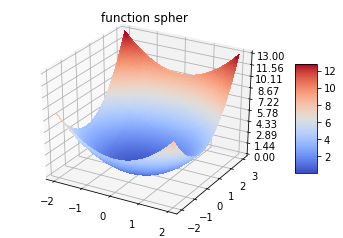

In [8]:
%matplotlib inline 
of.plot_fnc(of.spher)

As you can see sphere function's minimum value is 0, achieved at (0,0). 

Next, we create an instance of minpy.Minimization class, and call the optimization method (minimize_NM is stochastic extention of Nelder and Mead algorithm). then we can compare the result of optimization with optimal value we expect to see.

In [9]:
myclass = minpy.Minimization(of.spher,X0)

In [10]:
result = myclass.minimize_NM()

The result is a tuple : first element is optimal function value, second is the argument value where optimum is achieved

In [11]:
result

(3.7715202864647283e-06, array([-0.0015801 ,  0.00112908]))

Indeed, sphere has its minimum at 0

# Example 2

In this example we discuss optimization algorithms similar to original Nelder and Mead alorithm (NM). First variant (NM-stochastic) is very similar to NM but corrects some of its drawbacks, and second variant (NM-nonlocal) has some similarity to random search and helps to resolve some other issues of classical NM algorithm. 

Steps of NM-stochastic:
1. Initialize the search by generating $K\geq n$ separate realizations of $u_0^i$, i=1,..K of the random vector $U_0$,set $m_0=\frac{1}{K} \sum_{i=0}^{K} u_0^i$

2. On step j = 1, 2, ...

a.Compute the mean level $c_{j-1}=\frac{1}{K} \sum_{i=1}^K f(u_{j-1}^i)$

b.Calculate a new set of vertices:

$$u_j^i= m_{j-1}+\epsilon_{j-1} (f(u_{j-1}^i)-c_{j-1})\frac{  m_{j-1} -u_{j-1}^i}  {||m_{j-1} -u_{j-1}^i ||^n }$$

c.Set  $m_j=\frac{1}{K} \sum_{i=0}^K u_j^i$

d.Adjust the step size $\epsilon_{j-1}$ so that $f(m_j)<f(m_{j-1})$. If approximate $\epsilon _{j-1}$ cannot be obtained within the specified number of trails, then set $m_k=m_{j-1}$ 

e.Use sample standard deviation as termination criterion: $D_j=(\frac{1}{K-1} \sum_{i=1}^K (f(u_j^i)-c_j)^2)^{1/2}$

Note that classic simplex search methods do not use values of objective function to calculate reflection/expantion/contraction coefficients. Those coefficients are the same for all vertices, whereas in NM-stochastic the distance each vertex will travel depends on the difference between objective function value and average value across all vertices $(f(u_j^i)-c_j)$
In the above algorithm simlex may collapse into a nearly degenerate figure. The usually proposed remedy is to restart the simlex every once in a while.  Note that only initial vertices are randomly generated, and the path of all subsequent vertices is deterministic. 
In the next variant of the algorithm we will maintain the randomness of vertices on each step, while adjusting the distribution of $U_0$ to mimic the pattern of the modified vertices. The corrected algorithm has much higher exploration power than the first algorithm (similar to the exploration power of random search algorithms), and has exploitation power of direct - search algorithms.


Steps of NM - nonlocal

1. Choose a starting point $x_0$ and set $m_0=x_0$. Compute $(fm_0).$

2. On step j = 1, 2, ...
Obtain K separate realizations of $u_i^i$, i=1,..K of the random vector $U_j$

a.Compute $f(u_{j-1}^i) , j = 1,2,..K$, and the sample mean level $$c_{j-1}=\frac{1}{K} \sum_{i=1}^K f(u_{j-1}^i)$$

b.Generate the new estimate of the mean:

$$m_{j}= m_{j-1}+\epsilon_{j}\frac{1}{K} \sum_{i=1}^K[(f(u_{j}^i)-c_{j})\frac{  m_{j-1} -u_{j}^i}  {||m_{j-1} -u_{j}^i ||^n }]$$

Adjust the step size $\epsilon_{j-1}$ so that $f(m_j)<f(m_{j-1})$. If approximate $\epsilon _{j-1}$ cannot be obtained within the specified number of trails, then set $m_k=m_{j-1}$ 

c.Use sample standard deviation as termination criterion: $$D_j=(\frac{1}{K-1} \sum_{i=1}^K (f(u_j^i)-c_j)^2)^{1/2}$$

references
https://www.damtp.cam.ac.uk/user/reh10/lectures/nst-mmii-chapter2.pdf

# Example 3

The following demonstration shows how to create custom algorithms using basic modules from minpy. We create NM-stochastic algorithm as an example.

NM-stochastic will be constructed using the following building blocks

Initialization: 
 Generating $K\geq n$ separate realizations of $u_0^i$, i=1,..K of the random vector $U_0$
update_m: Compute  center of mass of initial simplex
 $$m_0=\frac{1}{K} \sum_{i=0}^{K} u_0^i$$
update_c: Compute mean level of objective 
$$c_{j-1}=\frac{1}{K} \sum_{i=1}^K f(u_{j-1}^i)$$
update_simplex: Compute new set of vertices $$u_j^i= m_{j-1}+\epsilon_{j-1} (f(u_{j-1}^i)-c_{j-1})\frac{  m_{j-1} -u_{j-1}^i}  {||m_{j-1} -u_{j-1}^i ||^n }$$
update_m: Compute  center of mass at step $j$
 $$m_j=\frac{1}{K} \sum_{i=0}^{K} u_j^i$$

adjust_step: Adjust the step size $\epsilon_{j-1}$ so that $f(m_j)<f(m_{j-1})$. If approximate $\epsilon _{j-1}$ cannot be obtained within the specified number of trails, then set $m_k=m_{j-1}$ 

stop: Check termination criterion - sample standard deviation: $$D_j=(\frac{1}{K-1} \sum_{i=1}^K (f(u_j^i)-c_j)^2)^{1/2}$$

In [15]:
from minpy import Minimization

class NM_Minimization(Minimization):
    
    def update_simplex(self):
        pass
       
    def NM_stochastic(self):
        self.initialize()
        self.update_m()
        while not self.stop():
            self.update_c()
            self.update_simplex()
            self.update_m()
            self.adjust_step()
        return self.get_best()

we apply this algorithm to Sphere function in 3d and to Shor function in 5d

In [16]:
from optfun import spher,shor

X0 = np.array([0.8,1.9])

onSphere = NM_Minimization(spher,X0)
res = onSphere.NM_stochastic()
print('sphere optimal function value:', round(res[0],3), ' at X:', round(res[1][0],3)   ,round(res[1][1],3)) 
print('***********')

X0 = np.array([0.8,1.9,-0.5,1.2,2.1])

onShor = NM_Minimization(shor,X0)
res = onShor.NM_stochastic()
print('shor optimal function value:', round(res[0],3), ' at X:', round(res[1][0],3)   ,round(res[1][1],3),
     round(res[1][1],3), round(res[1][2],3), round(res[1][3],3), round(res[1][4],3)) 
print('***********')

sphere optimal function value: 0.0  at X: 0.522 2.271
***********
shor optimal function value: 0.0  at X: 0.522 2.271 2.271 -0.793 1.619 2.088
***********
